# `haiku` Gaussian Mixture Model (GMM)

In [12]:
!pip install --quiet dm-haiku distrax chex optax watermark

In [15]:
import jax
import jax.numpy as jnp
import jax.random as random
import haiku as hk
import distrax
import optax
from chex import Array, PRNGKey
from typing import (
        Any, Optional, Sequence, Tuple, Dict)
from functools import partial

import numpy as np # for np.prod >: (

OptState = Any

In [18]:
import watermark.watermark as watermark
print(watermark(iversions=True, globals_=globals()))

numpy     : 1.21.6
matplotlib: 3.2.2
jax       : 0.3.14
distrax   : 0.1.2
haiku     : 0.0.7
optax     : 0.1.3
IPython   : 5.5.0



## Model

In [5]:
class GMM(hk.Module):
    """ Gaussian Mixture Model.
        Learns distribution of mixture of 'n_components' Gaussians parameterised
        by neural nets self.mu, self.sigma 
    """

    def __init__(
            self,
            # Simulation / parameter shapes
            event_shape: Sequence[int],
            context_shape: Sequence[int],
            # Number of independent Gaussians to use
            n_components: int,
            # Hidden units in parameterizations of means, sigams
            hidden_sizes: Sequence[int]):
        super().__init__()
        # GMM target variable definitions
        self.event_shape = event_shape
        self.context_shape = context_shape

        # GMM outputs n_component different (weight, mu, sigma) tuples
        self.n_components = n_components
        self.hidden_sizes = hidden_sizes + [self.n_components]
        net_kwargs = {
                "event_shape" : self.event_shape, 
                "context_shape" : self.context_shape,
                "n_components" : self.n_components,
                "hidden_sizes" : self.hidden_sizes}

        # GMM component nets 
        self.alpha = hk.nets.MLP(
            self.hidden_sizes,
            activate_final=True,
            activation=jax.nn.softmax)

        out_dim = [n_components * np.prod(self.context_shape)]
        self.mu = hk.nets.MLP(
            self.hidden_sizes + out_dim, 
            activate_final=True,
            activation=lambda x: x)
        self.sigma = hk.nets.MLP(
            self.hidden_sizes + out_dim,
            activate_final=True,
            activation=jax.nn.softmax)


    def __call__(self, parameters: Array) -> distrax.Distribution:
        # Component weights
        alphas = self.alpha(parameters).reshape(-1, self.n_components)
        # Means and sigmas
        out_shape = (self.n_components, ) + self.context_shape
        means = self.mu(parameters).reshape(-1, *out_shape) 
        sigmas = self.sigma(parameters).reshape(-1, *out_shape) 

        # GMM defined as a distribution. Mixture of neurally parameterised Gaussians.
        weights_dist = distrax.Categorical(probs=alphas) # alpha outputs 'n_components' weights
        components_dist = distrax.Normal(loc=means, scale=sigmas)
        
        if 0:
          print("alphas, means, sigmas")
          print(alphas.shape, means.shape, sigmas.shape)
    
        # Multidimensional version of the components distribution
        components_dist = distrax.MultivariateNormalDiag(
                loc=means, scale_diag=sigmas)
        
        gmm = distrax.MixtureSameFamily(
                mixture_distribution=weights_dist,
                components_distribution=components_dist)
        return gmm


    def log_prob(self, value: Array, context: Array) -> Array:
        return self.__call__(context).log_prob(value)

## Training functions

In [6]:
def make_gmm_model(**nde_kwargs):
    model = GMM(**nde_kwargs)
    return model

@hk.without_apply_rng
@hk.transform
def log_prob(
        # NDE args
        nde_args: Dict,
        # inputs
        simulations: Array,
        parameters: Array,
        pdfs: Optional[Array] = None) -> Array:
    """ Log probability of arbitrary NDE distribution. """
    model = make_gmm_model(**nde_args)
    return model.log_prob(value=simulations, context=parameters)


def loss_fn(
        params: hk.Params,
        nde_args: Dict,
        simulations: Array,
        parameters: Array,
        pdfs: Optional[Array] = None) -> Array:
    log_probs = log_prob.apply(
            params,
            nde_args,
            simulations=simulations,
            parameters=parameters,
            pdfs=pdfs)
    if pdfs is not None:
        loss = jnp.square(jnp.square(pdfs, log_probs)).mean()
    else:
        loss = -log_probs.mean()
    return loss, log_probs


@partial(jax.jit, static_argnums=(2, 3))
def update(
        # training
        params: hk.Params,
        opt_state: OptState,
        optimizer: optax.GradientTransformation, # => one for each NDE 
        # NDE args
        nde_args: Dict,
        # inputs
        simulations: Array,
        parameters: Array,
        pdfs: Optional[Array] = None) -> Tuple[hk.Params, OptState, Array, Array]:
    """ Run a single training step to update the model. """
    (loss, log_probs), grads = jax.value_and_grad(loss_fn, has_aux=True)(
            params,
            nde_args=nde_args,
            simulations=simulations,
            parameters=parameters,
            pdfs=pdfs)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, loss, log_probs


@partial(jax.jit, static_argnums=1)
def eval_fn(
        params: hk.Params,
		    # nde args 
        nde_args: Dict,
        # inputs
        simulations: Array,
        parameters: Array,
        pdfs: Optional[Array] = None) -> Tuple[Array, Array]:
    log_probs = log_prob.apply(
			    params, 
          # nde args
          nde_args=nde_args,
			    # inputs
          simulations=simulations, 
          parameters=parameters,
          pdfs=pdfs)
    if pdfs is not None:
        loss = jnp.square(jnp.subtract(pdfs, log_probs)).mean()
    else:
        loss = -log_probs.mean()
    return loss, log_probs


## Run training

In [7]:
import matplotlib.pyplot as plt 

prng_seq = hk.PRNGSequence(0)

# dimensionality of random variable
n_dims = 3

# Get some toy data with labels based on points quadrant: positive or negative
X = jax.random.normal(next(prng_seq), (1000, n_dims))
Y = jax.scipy.stats.multivariate_normal.logpdf(X, mean=jnp.zeros(n_dims), cov=jnp.eye(n_dims))
Y = jnp.ones(X.shape)
Y = Y.at[X < 0.0,...].set(0.0)
X_ = jax.random.normal(next(prng_seq), (1000, n_dims))
Y_ = jax.scipy.stats.multivariate_normal.logpdf(X, mean=jnp.zeros(n_dims), cov=jnp.eye(n_dims))
Y_ = jnp.ones(X_.shape)
Y_ = Y_.at[X_ < 0.0,...].set(0.0) 

print("DATA:")
print("X", X.shape)
print("Y", Y.shape)

nde_kwargs = {
        "context_shape" : (n_dims,),
        "event_shape" : (n_dims,),
        "n_components" : 5,
        "hidden_sizes" : [32, 16, 8]} # n_components output shape added within GMM class

print("GMM model with specifciation:\n", nde_kwargs)

nde_kwargs = hk.data_structures.to_immutable_dict(nde_kwargs)

optim = optax.adam(0.001)
params = log_prob.init(
        next(prng_seq), 
        nde_args=nde_kwargs,
        simulations=X[:3],
        parameters=Y[:3],
        pdfs=None)
opt_state = optim.init(params)

batch_size = 128
n_steps = 10000
train_losses = []
val_losses = []
for i in range(n_steps):
    # prepare random batch
    idx = random.choice(next(prng_seq), jnp.arange(len(X)), (batch_size,))
    x, y = X[idx], Y[idx]     # train
    x_, y_ = X_[idx], Y_[idx] # valid

    (
        params, 
        opt_state, 
        train_loss, 
        train_log_probs
    ) = update(
            params, 
            opt_state=opt_state, 
            optimizer=optim, 
            nde_args=nde_kwargs, 
            simulations=x, 
            parameters=y)
    
    val_loss, val_log_probs = eval_fn(
            params, 
            nde_args=nde_kwargs, 
            simulations=x_, 
            parameters=y_)
    
    val_losses.append(val_loss)
    train_losses.append(train_loss)
    if i % 100 == 0:
        print(f"\rStep={i + 100}/{n_steps} train={train_loss:.3f} val={val_loss:.3f}", end="")

DATA:
X (1000, 3)
Y (1000, 3)
GMM model with specifciation:
 {'context_shape': (3,), 'event_shape': (3,), 'n_components': 5, 'hidden_sizes': [32, 16, 8]}
Step=9900/10000 train=4.522 val=4.224

In [8]:
# 5 is arbitrary batch size
x = jax.random.normal(next(prng_seq), (5, ) + (n_dims,))
y = jax.random.uniform(next(prng_seq), (5, ) + (n_dims,)) 
p = log_prob.apply(
    params, nde_kwargs, simulations=x, parameters=y)
print(p, p.shape)

[-12.44873  -12.423923  -1.100054 -56.732246 -20.170458] (5,)


### Show losses

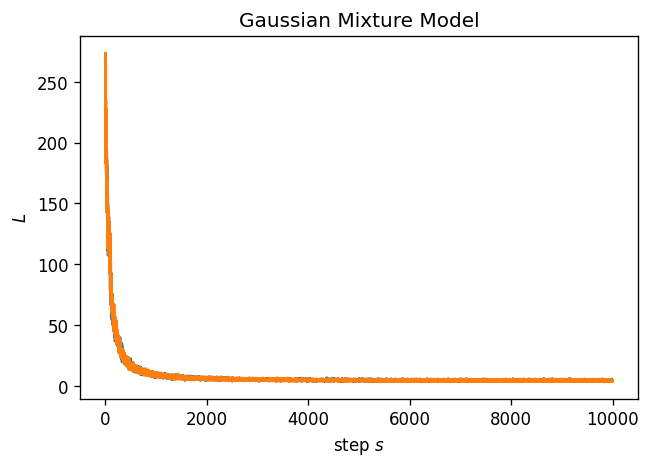

In [9]:
plt.figure(dpi=120)
plt.title("Gaussian Mixture Model")
plt.ylabel(r"$L$")
plt.xlabel(r"step $s$")
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [10]:
# You didn't see this coming!
1. - jnp.inf

-inf